In [1]:
import csv
import sys
import os
import math
import numpy as np
import numpy.linalg as npla
import scipy
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
%matplotlib tk
import operator

In [2]:
import sys
sys.path.append("../Python_code") # go to parent dir
from reddit import *

In [3]:
js_filename = "../data/atlas_filtered.json"

names, descriptions = read_picture_names_and_descriptions(js_filename)

In [249]:
#FIXME: Here, I believe we should distinguish between updates that aggree with the project and updates
#that disagree with it. Notice that updates that agree are different from pixels, as they might not have 
#survived to the end of the experiment. Maybe these should be named updates_for_project and
#updates_against_project. The current updates_per_project is the sum of the two. This will 
#require updating a lot of these results, as each type of update will be analyzed in separate.

updates_per_project = dict()

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/updates_per_project.csv",'r') as file:
    # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        if r[0] not in projects_to_remove:
            updates_per_project[r[0]] = int(r[-1])

In [250]:
count = np.zeros(max(updates_per_project.values())+1)

for k in updates_per_project:
    count[updates_per_project[k]] = count[updates_per_project[k]] + 1
    
for i in reversed(range(len(count)-1)):
    count[i] = count[i] + count[i+1]
    
count = count / count[0]

In [251]:
sorted_up_proj = sorted(updates_per_project.items(), key=operator.itemgetter(1), reverse=True)

In [20]:
#Top-10

for i in range(10):
    proj = sorted_up_proj[i][0]
    up = sorted_up_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", updates: ", up, ", \ndescription: ", desc, "\n")

# 0 Project:  Rainbow Road , updates:  1078220 , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 Project:  USA / Canvas Center , updates:  684179 , 
description:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as well. A net of yellow lines appeared and took over the void and r/AmericanFlaginPlace with help of r/TheDonald and other red

In [22]:
#Bottom-10

for i in range(1,11):
    proj = sorted_up_proj[-i][0]
    up = sorted_up_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", updates: ", up, ", \ndescription: ", desc, "\n")

# 1 Project:  Climber's Head (TowerClimb) , updates:  3 , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 Project:  Eightfold , updates:  55 , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 3 Project:  Tiny danish flag , updates:  61 , 
description:  denmark is a samll nation in the nothern part of europe 

# 4 Project:  Smiley Face , updates:  66 , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 5 Project:  Italy heart , updates:  75 , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 6 Project:  The R , updates:  82 , 
description:  The R of the sub r/The_R 

# 7 Project:  Stealth Pepe , updates:  82 , 
description:  Pepe the frog was placed and overwritten with prejudice many times, but this one survived by being tiny, the rarest of them all 

In [23]:
#AVG

print("AVG = ", np.mean(np.array(list(updates_per_project.values()))))

AVG =  15923.549868073878


In [24]:
#STD

print("STD = ", np.std(np.array(list(updates_per_project.values()))))

STD =  52332.93157519816


In [230]:
sorted_up_proj_vals = []

for p in sorted_up_proj:
    sorted_up_proj_vals.append(p[1])

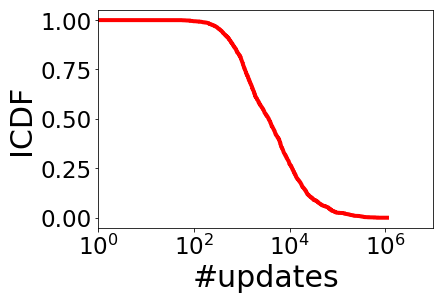

In [219]:
def plot_updates_per_project_icdf(count, output_file_name):
    plt.clf()
    ax = plt.subplot(111)
    ax.semilogx(range(len(count)), count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#updates', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_yticks(np.arange(0, 1.1, .25))
    ax.set_xlim(1,10000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_per_project_icdf(count, "../plots/plot_updates_per_project_icdf.svg")

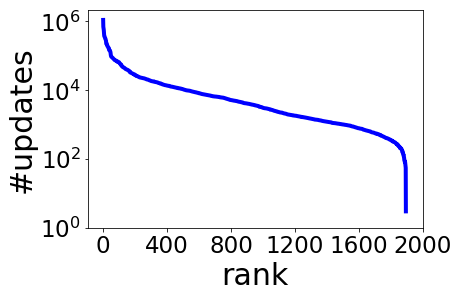

In [252]:
def plot_updates_per_project_rank(sorted_up_proj, output_file_name):
    plt.clf()
    ax = plt.subplot(111)
    ax.semilogy(np.arange(len(sorted_up_proj)), sorted_up_proj, color="blue", linewidth=4)
    ax.set_ylabel('#updates', fontsize=30)
    ax.set_xlabel('rank', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(None,2000)
    ax.set_xticks(np.arange(0,2001,400))
    ax.set_ylim(1,None)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_per_project_rank(sorted_up_proj_vals, "../plots/plot_updates_per_project_rank.svg")

In [239]:
#FIXME: It seems like there is something wrong with the computation of entropy. 
#I have seen some projects with one pixel for which the entropy is not zero. 
#Please, check.

# Color Entropy
# This is a discrete distribution but should probably be continuous (?)
entropy_per_project = {}

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/color_per_picture_entropy.csv", 'r') as file:
    # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        if r[1] != 'NA' and r[0] not in projects_to_remove:
            entropy_per_project[r[0]] = float(r[1])

In [240]:
entropy = sorted(list(entropy_per_project.values()))

count = np.arange(len(entropy)+1)[len(entropy)+1:0:-1]
count = count / count[0]

In [241]:
sorted_ent_proj = sorted(entropy_per_project.items(), key=operator.itemgetter(1), reverse=True)

In [242]:
sorted_ent_proj_vals = []

for p in sorted_ent_proj:
    sorted_ent_proj_vals.append(p[1])

In [33]:
#Top-10

for i in range(10):
    proj = sorted_ent_proj[i][0]
    ent = sorted_ent_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndescription: ", desc, "\n")

# 0 Project:  Star Citizen Ship , entropy:  2.62879857641316 , 
description:  A last-minute addition to /r/ainbowroad, the beginning of a StarCitzen Spaceship. The place finished before it could be completed. 

# 1 Project:  Miss Fortune , entropy:  2.626443010876863 , 
description:  Pixel art of a Champion from the game League of Legends called Miss Fortune, the Bounty Hunter.<br>Created by a small group of about 7 redditors. 

# 2 Project:  Rainbow Road Core , entropy:  2.6200140250781163 , 
description:  One of the earliest major faction on Place. They spread from here originally. After a while they began allowing others to build art in their space, making peace treaties and agreements with other factions 

# 3 Project:  Slushii , entropy:  2.579472788144371 , 
description:  Slush it up 

# 4 Project:  Yoshi , entropy:  2.562170079369621 , 
description:  Yoshi from Mario Kart about to hit the Banana Peel item. 

# 5 Project:  CUL , entropy:  2.5608575975838828 , 
description:  CUL m

In [35]:
#Bottom-10

for i in range(1,11):
    proj = sorted_ent_proj[-i][0]
    ent = sorted_ent_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", \ndescription: ", desc, "\n")

# 1 Project:  PINLAND , entropy:  0.6928361704898555 , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 2 Project:  (covered) 7-1 , entropy:  0.7545123567706904 , 
description:  The corner of the Brazil Flag that was vandalized over in over again in an attempt to shame Brazil for their 7-1 defeat against Germany in the 2014 world cup. Now all that remains is a single pixel of where the 7 starts 

# 3 Project:  Hanzo Switch Pls , entropy:  0.962231222075264 , 
description:  After initially writing "Switch" here, the words "Hanzo" and "pls" were added before and after it respectively to say "Hanzo Switch pls". Hanzo is a hero from the Blizzard game Overwatch who is considered bad and often when someone picks him people ask him to switch to a different hero. 

# 4 Project:  Anarchocapitalist flag , entropy:  0.9898549174012896 , 
description:  The yellow/black anarchocapitalist flag, showing signs of vandalism, apparently from left-wing a

In [36]:
#AVG

print("AVG = ", np.mean(np.array(list(entropy_per_project.values()))))

AVG =  1.9625622892120833


In [37]:
#STD

print("STD = ", np.std(np.array(list(entropy_per_project.values()))))

STD =  0.2776220208605374


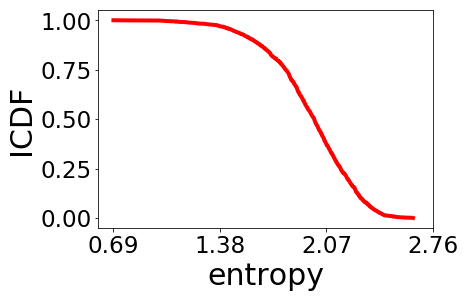

In [225]:
%matplotlib inline
def plot_color_entropies_per_project_icdf(entropy, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(entropy, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_yticks(np.arange(0, 1.1, .25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_color_entropies_per_project_icdf(entropy, count, "../plots/plot_color_entropies_icdf.svg")

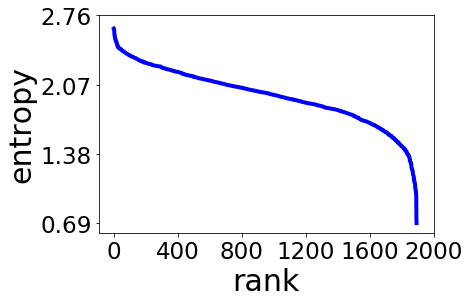

In [243]:
%matplotlib inline
def plot_color_entropies_per_project_rank(sorted_ent_proj, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(sorted_ent_proj, color="blue", linewidth=4)
    ax.set_ylabel('entropy', fontsize=30)
    ax.set_xlabel('rank', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_yticks(np.arange(.69,math.exp(1)+.1, .69))
    ax.set_xlim(None,2000)
    ax.set_xticks(np.arange(0,2001,400))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_color_entropies_per_project_rank(sorted_ent_proj_vals, "../plots/plot_color_entropies_rank.svg")

In [253]:
# Pixels per Project
pixels_per_project = {}

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/pixels_per_project.csv", 'r') as file:
     # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        if r[0] not in projects_to_remove:
            pixels_per_project[r[0]] = int(r[1])

In [254]:
pixels = sorted(list(pixels_per_project.values()))

count = np.arange(len(pixels)+1)[len(pixels)+1:0:-1]
count = count / count[0]

In [255]:
sorted_pixels_proj = sorted(pixels_per_project.items(), key=operator.itemgetter(1), reverse=True)

In [256]:
sorted_pixels_proj_vals = []

for p in sorted_pixels_proj:
    sorted_pixels_proj_vals.append(p[1])

In [47]:
#Top-10

for i in range(10):
    proj = sorted_pixels_proj[i][0]
    pix = sorted_pixels_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", \ndescription: ", desc, "\n")

# 0 Project:  Rainbow Road , pixels:  87255 , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 Project:  Entire Dutch Area , pixels:  32920 , 
description:  Complete area built by Dutch subreddits 

# 2 Project:  The untold history , pixels:  22926 , 
description:  The tale of Darth Plagueis the wise 

# 3 Project:  Darth Plagueis The Wise , pixels:  21406 , 
description:  One of the first additions to the map, this text of a meme from the prequel Star Wars movies started out as an uncoordinated attempt to write something everyone knew, and was refined to the masterpiece you see today. 

# 4 Project:  Did you ever hear the Tragedy of Darth Plagueis the Wise? , pixels:  21401 , 
description:  It's a Sith legend. Darth Plagueis was a Dark Lord of the Sith so powerful and so wise, he could use the Force to influence the midi-chlorians to create...life. He had such a knowledge of the Dark Side, he could e

In [48]:
#Bottom-10

for i in range(1,11):
    proj = sorted_pixels_proj[-i][0]
    pix = sorted_pixels_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", \ndescription: ", desc, "\n")

# 1 Project:  Climber's Head (TowerClimb) , pixels:  1 , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 Project:  PINLAND , pixels:  2 , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 3 Project:  The purple corner , pixels:  4 , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 4 Project:  Eightfold , pixels:  5 , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 5 Project:  Stealth Pepe , pixels:  8 , 
description:  Pepe the frog was placed and overwritten with prejudice many

In [49]:
#AVG

print("AVG = ", np.mean(np.array(list(pixels_per_project.values()))))

AVG =  890.8981530343008


In [50]:
#STD

print("STD = ", np.std(np.array(list(pixels_per_project.values()))))

STD =  2842.5359929860856


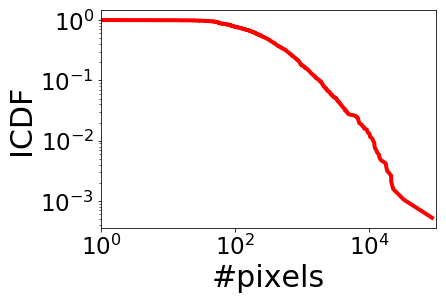

In [248]:
%matplotlib inline
def plot_pixels_per_project_icdf(pixels, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.loglog(pixels, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(1,100000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_per_project_icdf(pixels, count, "../plots/plot_pixels_icdf.svg")

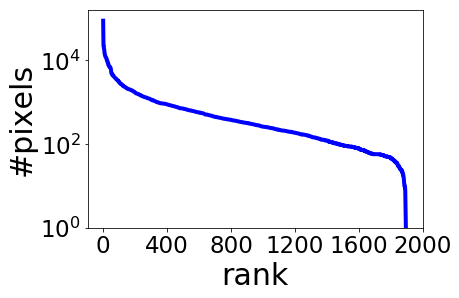

In [257]:
%matplotlib inline
def plot_pixels_per_project_rank(sorted_pixels_proj, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.semilogy(sorted_pixels_proj, color="blue", linewidth=4)
    ax.set_ylabel('#pixels', fontsize=30)
    ax.set_xlabel('rank', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(None,2000)
    ax.set_xticks(np.arange(0,2001,400))
    ax.set_ylim(1,None)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_per_project_rank(sorted_pixels_proj_vals, "../plots/plot_pixels_rank.svg")

In [258]:
projects_per_user = {}

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/projects_per_user.csv", 'r') as file:
     # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        str_proj = r[1][2:-2]
        lst_proj = str_proj.split(',')
        
        projects_per_user[r[0]] = 0
        
        for p in lst_proj:
            if p not in projects_to_remove:
                projects_per_user[r[0]] = projects_per_user[r[0]] + 1

In [259]:
proj_user = sorted(list(projects_per_user.values()))

count = np.arange(len(proj_user)+1)[len(proj_user)+1:0:-1]
count = count / count[0]

In [260]:
sorted_proj_user = sorted(projects_per_user.items(), key=operator.itemgetter(1), reverse=True)

In [261]:
sorted_proj_user_vals = []

for p in sorted_proj_user:
    sorted_proj_user_vals.append(p[1])

In [57]:
#Top-10

sorted_proj_user[0:10]

[('oV/QBQVpRBPm5K4UoK73KXfcG0o=', 352),
 ('yluQzhGix6Kb3RuJ1OyUUTxskhQ=', 330),
 ('OsnDa+2E+woJy7TN3U87yLQrbu8=', 325),
 ('8xow27kDaned3b13ENiuQT9fmRE=', 307),
 ('ZSPEY69+JkkBBY/a3gb/jUvXIgA=', 298),
 ('6AV6Kp/ChSlyKzHwgDGkWEScUJM=', 246),
 ('gIIoT+oPbML64+byH2Ms6FIj1sM=', 237),
 ('lnmjEGEWgq+s9joisWlkVYoEaUA=', 226),
 ('CeS6AznWDvF1LY9EIwB6ejhUCHM=', 192),
 ('lkQQqlMgmDd++vZn92bq65h8Teo=', 188)]

In [58]:
#Bottom-10

sorted_proj_user[-10:]

[('1z6NesrdQL+4m0rSQ2lS819GuxQ=', 1),
 ('juJM6hFOzY8R+DlNbtcrHh7KhJw=', 1),
 ('goLKZy/GA7PHVNNKT73JsTqxHp0=', 1),
 ('vyf5Xy7+nkf4ufzQ9wmu+2cxkaM=', 1),
 ('fuifxwogs4tD3vflBPq458V6SNQ=', 1),
 ('gcZZ6P2eEo1QJ5pqTZJoNjAW81A=', 1),
 ('Q4k7cdcbFf2xOrLyun0nqjFg5/U=', 1),
 ('aiq2IR1mg9cyogrEwv6m7DG9Wl4=', 1),
 ('ewkwRrQUfFwNj4k3UowcLZiG5LQ=', 1),
 ('65klnVPpsifHGq9Sxv9j/VagWK4=', 1)]

In [59]:
#AVG

print("AVG = ", np.mean(np.array(list(projects_per_user.values()))))

AVG =  9.229389403251625


In [60]:
#STD

print("STD = ", np.std(np.array(list(projects_per_user.values()))))

STD =  8.541646649948019


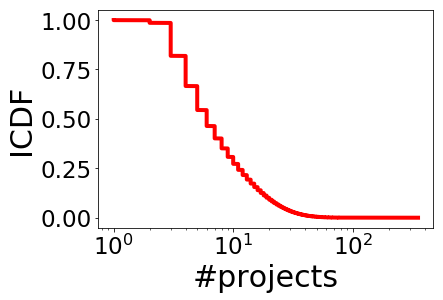

In [264]:
%matplotlib inline
def plot_projects_per_user_icdf(proj_user, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.semilogx(proj_user, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#projects', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_yticks(np.arange(0,1.1,0.25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_projects_per_user_icdf(proj_user, count, "../plots/plot_proj_user_icdf.svg")

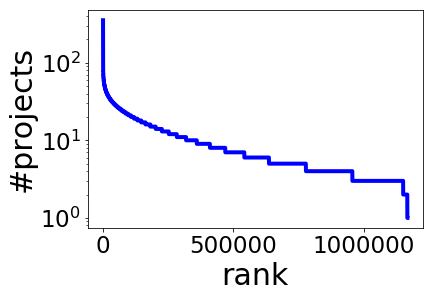

In [265]:
%matplotlib inline

def plot_projects_per_user_rank(sorted_proj_user, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.semilogy(sorted_proj_user, color="blue", linewidth=4)
    ax.set_ylabel('#projects', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('rank', fontsize=30)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_projects_per_user_rank(sorted_proj_user_vals, "../plots/plot_proj_user_rank.svg")

In [64]:
# Users per Project
users_per_project = {}

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/users_per_project.csv", 'r') as file:
     # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        if r[0] not in projects_to_remove:
            users_per_project[r[0]] = int(r[1])

In [65]:
user_proj = sorted(list(users_per_project.values()))

count = np.arange(len(user_proj)+1)[len(user_proj)+1:0:-1]
count = count / count[0]

In [66]:
sorted_user_proj = sorted(users_per_project.items(), key=operator.itemgetter(1), reverse=True)

In [67]:
sorted_user_proj_vals = []

for p in sorted_user_proj:
    sorted_user_proj_vals.append(p[1])

In [68]:
#Top-10

for i in range(10):
    proj = sorted_user_proj[i][0]
    usr = sorted_user_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", \ndescription: ", desc, "\n")

# 0 Project:  Rainbow Road , users:  266766 , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 1 Project:  USA / Canvas Center , users:  158121 , 
description:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as well. A net of yellow lines appeared and took over the void and r/AmericanFlaginPlace with help of r/TheDonald and other redditor

In [69]:
#Bottom-10

for i in range(1,11):
    proj = sorted_user_proj[-i][0]
    usr = sorted_user_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", \ndescription: ", desc, "\n")

# 1 Project:  Climber's Head (TowerClimb) , users:  3 , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 Project:  The R , users:  25 , 
description:  The R of the sub r/The_R 

# 3 Project:  Smiley Face , users:  26 , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 4 Project:  Italy heart , users:  32 , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 5 Project:  Make Trade Fair , users:  35 , 
description:  An organization supported by frontman Chris Martin of Coldplay drawn by the nearby Coldplay redditors. 

# 6 Project:  Eightfold , users:  38 , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 7 Project:  Green Carrot , users:  41 , 
description:  One of the few surviving carrots from /r/farmcarrots. Its colors have been swapped making it a g

In [70]:
#AVG

print("AVG = ", np.mean(np.array(list(users_per_project.values()))))

AVG =  4452.32401055409


In [71]:
#STD

print("STD = ", np.std(np.array(list(users_per_project.values()))))

STD =  12926.262884446302


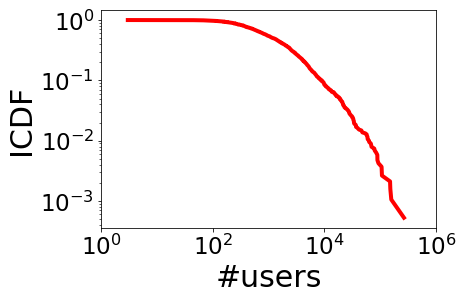

In [72]:
%matplotlib inline
def plot_users_per_project_icdf(user_proj, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.loglog(user_proj, count, color="red", linewidth=4)
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlim(1, 1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_per_project_icdf(user_proj, count, "../plots/plot_user_proj_icdf.svg")

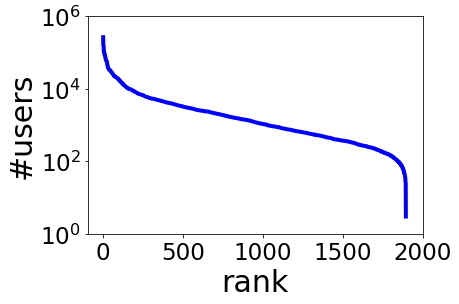

In [73]:
def plot_users_per_project_rank(sorted_user_proj, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.semilogy(sorted_user_proj, color="blue", linewidth=4)
    ax.set_ylabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('rank', fontsize=30)
    ax.set_xticks(np.arange(0, 2001, 500))
    ax.set_ylim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_per_project_rank(sorted_user_proj_vals, "../plots/plot_user_proj_rank.svg")

In [266]:
# Time
times_per_project = {}

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
projects_to_remove = {'777', '1921', '1240', '1516', '1319'}

with open("../data/times_per_project.csv", 'r') as file:
     # Skip first line (header row)
    next(file, None)
    reader = csv.reader(file)
    for r in reader:
        if r[3] != 'NA' and r[0] not in projects_to_remove:
            times_per_project[r[0]] = int(r[3])

In [267]:
time_proj = sorted(list(times_per_project.values()))

count = np.arange(len(time_proj)+1)[len(time_proj)+1:0:-1]
count = count / count[0]

In [268]:
sorted_time_proj = sorted(times_per_project.items(), key=operator.itemgetter(1), reverse=True)

In [269]:
sorted_time_proj_vals = []

for p in sorted_time_proj:
    sorted_time_proj_vals.append(p[1])

In [79]:
#Top-10

for i in range(10):
    proj = sorted_time_proj[i][0]
    tm = sorted_time_proj[i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", \ndescription: ", desc, "\n")

# 0 Project:  Nine Inch Nails , time:  304153000 , 
description:  The logo of the industrial rock band Nine Inch Nails, appropriately glitched out by random pixels. 

# 1 Project:  Mona Lisa , time:  259159000 , 
description:  In order to prove the point that reddit users are a cultured bunch, a group of them set out to recreate Leonardo da Vinci's Mona Lisa. 

# 2 Project:  University of Colorado Boulder , time:  259111000 , 
description:  The CU buffalo is the mascot of the University of Colorado Boulder, USA. The university sponsors 17 varsity sports teams. Both the men's and women's teams are called the Buffaloes or, rarely, the Golden Buffaloes.  

# 3 Project:  University of Colorado Boulder , time:  259111000 , 
description:  The CU buffalo, mascot of University of Colorado  Boulder 

# 4 Project:  Album covers , time:  258812000 , 
description:  Two album covers mainly constructed by /r/indieheads. The first, on the right, is Neutral Milk Hotel's 'In the Aeroplane Over the Sea'

In [80]:
#Bottom-10

for i in range(1,11):
    proj = sorted_user_proj[-i][0]
    tm = sorted_time_proj[-i][1]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", \ndescription: ", desc, "\n")

# 1 Project:  Climber's Head (TowerClimb) , time:  0 , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 Project:  The R , time:  1105000 , 
description:  The R of the sub r/The_R 

# 3 Project:  Smiley Face , time:  1835000 , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 4 Project:  Italy heart , time:  2390000 , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 5 Project:  Make Trade Fair , time:  3008000 , 
description:  An organization supported by frontman Chris Martin of Coldplay drawn by the nearby Coldplay redditors. 

# 6 Project:  Eightfold , time:  4596000 , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 7 Project:  Green Carrot , time:  5142000 , 
description:  One of the few surviving carrots from /r/farmcarrots. Its colors have bee

In [81]:
#AVG

print("AVG = ", np.mean(np.array(list(times_per_project.values())))/(1000 * 60 * 60))

AVG =  53.34995411902668


In [82]:
#STD

print("STD = ", np.std(np.array(list(times_per_project.values())))/(1000 * 60 * 60))

STD =  18.76175419445967


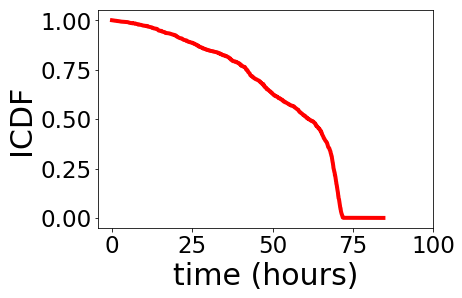

In [274]:
%matplotlib inline
def plot_times_per_project_icdf(time_proj, count, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(np.array(time_proj)/(1000*60*60), count, color="red", linewidth=4) #millisecons to hours
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xticks(np.arange(0,101,25))
    ax.set_xlim(None, 100)
    ax.set_yticks(np.arange(0,1.1,0.25))
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_times_per_project_icdf(time_proj, count, "../plots/plot_time_proj_icdf.svg")

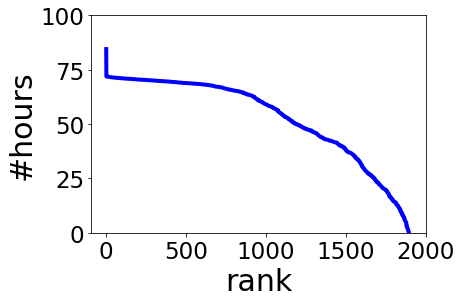

In [275]:
def plot_times_per_project_rank(sorted_time_proj, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.plot(np.array(sorted_time_proj)/(1000*60*60), color="blue", linewidth=4)
    ax.set_ylabel('#hours', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('rank', fontsize=30)
    ax.set_xticks(np.arange(0, 2001, 500))
    ax.set_ylim(0,100)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_times_per_project_rank(sorted_time_proj_vals, "../plots/plot_time_proj_rank.svg")

In [357]:
#Updates vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    ent = entropy_per_project[p]
    
    X[i] = up
    Y[i] = ent
    
    ratios[p] = ent / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [359]:
#Showing project IDs on mouse hovering. Based on:
#https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib

%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yticks(np.arange(np.min(Y),math.exp(1)+.1, .69))
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

<Figure size 432x288 with 0 Axes>

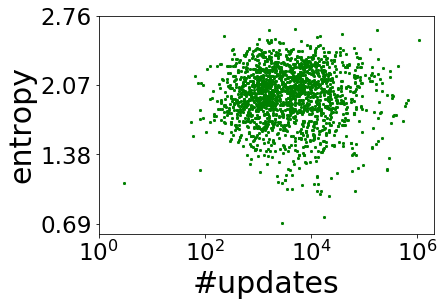

In [160]:
def plot_updates_vs_entropy(X, Y, output_file_name):
    plt.clf()

    fig, ax = plt.subplots()
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xlim(1,None)
    
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_entropy(X, Y, "../plots/plot_updates_vs_entropy.svg")

In [88]:
#Correlation

np.corrcoef(X, Y)

array([[ 1.        , -0.01240211],
       [-0.01240211,  1.        ]])

In [89]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [94]:
#Entropy/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", updates: ", up, ", entropy/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , updates:  3 , entropy/update:  0.36620409622270317         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Smiley Face , entropy:  2.1679025503594818 , updates:  66 , entropy/update:  0.03284700833878003         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  Eightfold , entropy:  1.7075036453641854 , updates:  55 , entropy/update:  0.03104552082480337         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 3 , project:  Italy heart , entropy:  2.0908155810619586 , updates:  75 , entropy/update:  0.027877541080826115         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 4 , project:  Tiny danish flag , entropy:  1.5603830291635967 , 

In [100]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, "project: ", p, "entropy: ", ent, " updates: ", up, " entropy/update: ", r,"\
        ndescription: ", desc, "\n")    

# 1 project:  1066 entropy:  2.5201075806834554  updates:  1078220  entropy/update:  2.337285137247923e-06         ndescription:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 project:  1066 entropy:  1.9258022777284207  updates:  684179  entropy/update:  2.814763793873271e-06         ndescription:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opportunity  and decided to expand as

In [360]:
#Updates vs. pixels per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    pix = pixels_per_project[p]
    
    X[i] = up
    Y[i] = pix
    
    ratios[p] = pix / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [361]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#pixels', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,None)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

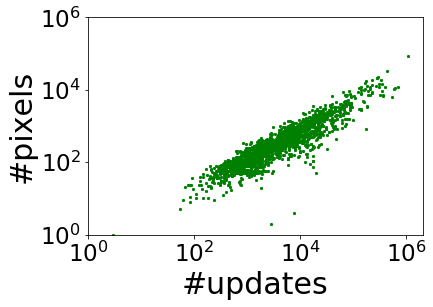

In [169]:
def plot_updates_vs_pixels(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#pixels', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,None)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_pixels(X, Y, "../plots/plot_updates_vs_pixels.svg")

In [103]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.84277543],
       [0.84277543, 1.        ]])

In [104]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [106]:
#Pixels/update
    
for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    pix = pixels_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", updates: ", up, ", pixels/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Seplunky , pixels:  336 , updates:  821 , pixels/update:  0.4092570036540804         , 
description:  Player character from the platform indie game Spelunky. 

# 1 , project:  Bread , pixels:  65 , updates:  167 , pixels/update:  0.38922155688622756         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 2 , project:  Amaura , pixels:  36 , updates:  93 , pixels/update:  0.3870967741935484         , 
description:  The head of the Generation 6 Fossil Pokémon Amaura. The body was covered up by surrounding art. 

# 3 , project:  Bread , pixels:  77 , updates:  203 , pixels/update:  0.3793103448275862         , 
description:  It's brea

In [108]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    pix = pixels_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", pixels: ", pix, ", updates: ", up, ", pixels/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 1 , project:  The purple corner , pixels:  4 , updates:  7701 , pixels/update:  0.0005194130632385404         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 2 , project:  PINLAND , pixels:  2 , updates:  2872 , pixels/update:  0.0006963788300835655         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 3 , project:  Trans Heart , pixels:  51 , updates:  19655 , pixels/update:  0.0025947596031544134         , 
description:  The first heart created by /r/TransFlagPlace, marking the centerpoint of the flag. 

# 4 , project:  (covered) 7-1 , pixels:  72 , updates:  17723 , pixels/update:  0.004062517632455002         ,

In [362]:
#Updates vs. users per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    usr = users_per_project[p]
    
    X[i] = up
    Y[i] = usr
    
    ratios[p] = usr / up
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [363]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#users', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,None)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

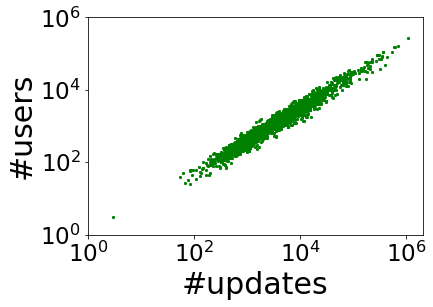

In [171]:
def plot_updates_vs_users(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,None)
    
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_users(X, Y, "../plots/plot_updates_vs_users.svg")

In [126]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.13952994],
       [0.13952994, 1.        ]])

In [127]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [116]:
#Users/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    usr = users_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", updates: ", up, ", users/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 0 , project:  Climber's Head (TowerClimb) , users:  3 , updates:  3 , users/update:  1.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Remnants of a Pokeball , users:  1295 , updates:  1486 , users/update:  0.8714670255720054         , 
description:  Remnants of a small pokeball. 

# 2 , project:  Pokeball , users:  1404 , updates:  1669 , users/update:  0.8412222887956861         , 
description:   

# 3 , project:  Pokéball , users:  1477 , updates:  1768 , users/update:  0.8354072398190046         , 
description:  A device used to capture Pokémon. 

# 4 , project:  Google Android Head , users:  645 , updates:  780 , users/update:  0.8269230769230769         , 
description:  Head of the Google Android created by /u/Jestified 

# 5 , project:  Pokeball , users:  1533 , updates:  1854 , users/update:  0.8268608414239482         , 
description:  An item from the Pokemon f

In [117]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    usr = users_per_project[proj]
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", updates: ", up, ", users/update: ", r, "\
        , \ndescription: ", desc, "\n")

# 1 , project:  University Of Texas at Austin , users:  1759 , updates:  15686 , users/update:  0.11213821241871733         , 
description:  University located in Austin, Texas USA. Their school colors are white and burnt orange.   

# 2 , project:  The Far Left Side , users:  36757 , updates:  324259 , users/update:  0.11335691530535776         , 
description:  The Far left side was made up of dedicated Leftists working together to create a community on r/place 

# 3 , project:  The Far Left Side , users:  47034 , updates:  402175 , users/update:  0.1169490893267856         , 
description:  The section of the canvas mostly filled with Leftist symbols, but also including pixel art and flags. <br>This area was under near-constant siege, especially the Hammer and Sickle. 

# 4 , project:  Hammer and Sickle , users:  20180 , updates:  171275 , users/update:  0.11782221573492921         , 
description:  Symbol of workers tools used to represent communism. 

# 5 , project:  Three bikes in t

In [364]:
#Updates vs. time

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    up = updates_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    X[i] = up
    Y[i] = t
    
    ratios[p] = t / up
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [365]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('time (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#updates', fontsize=30)
ax.set_xscale('log')
ax.set_xlim(1,None)
ax.set_ylim(0,100)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

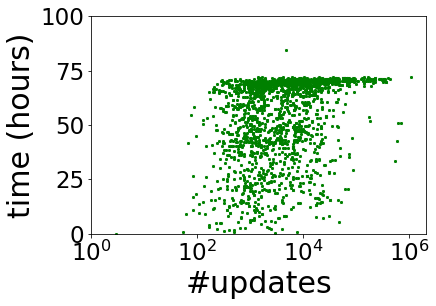

In [176]:
def plot_updates_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#updates', fontsize=30)
    ax.set_xscale('log')
    ax.set_xlim(1,None)
    ax.set_ylim(0,100)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_updates_vs_times(X, Y, "../plots/plot_updates_vs_times.svg")

In [130]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.13952994],
       [0.13952994, 1.        ]])

In [185]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [186]:
#Time/update

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", updates: ", up, ", times/update: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Italy heart , time:  54.689166666666665 , updates:  75 , times/update:  0.7291888888888889         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 1 , project:  Red P , time:  58.28722222222222 , updates:  86 , times/update:  0.6777583979328164         , 
description:  Seeing the whole work was an amazing piece of modern art, I really wanted to be a part of it. I decided to find a small unused spot and put my initial there. The void and erase factions were savage and had wiped two previous efforts and a larger piece of art I was helping maintain, so I found a spot and used a script running on 2 PC's to maintain my small part of the artwork until place ended, which happened while I was sleeping. 

# 2 , project:  Smiley Face , time:  41.72138888888889 , updates:  66 , times/update:  0.6321422558922559         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 3 , project:  Ama

In [187]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    up = updates_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", updates: ", up, ", times/update: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , updates:  3 , times/update:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  osu! Logo , time:  33.25222222222222 , updates:  540508 , times/update:  6.152031463405208e-05         , 
description:  The logo for the rhythm game osu. This was one of the more ambitious projects of /r/place and was intended to be more detailed. Unfortunately, a LoL player by the name of loltyler1, told his fans to attack the logo by filling it with the void, resulting in its current vandalized state. 

# 3 , project:  The purple corner , time:  0.5097222222222222 , updates:  7701 , times/update:  6.618909521130012e-05         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually bec

In [366]:
#Pixels vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    ent = entropy_per_project[p]
    pix = pixels_per_project[p]
    
    Y[i] = ent
    X[i] = pix
    
    ratios[p] = ent / pix
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [367]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
ax.set_xscale('log')
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

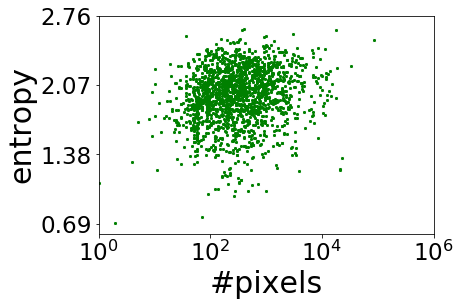

In [189]:
def plot_pixels_vs_entropy(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xscale('log')
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_entropy(X, Y, "../plots/plot_pixels_vs_entropy.svg")

In [139]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.07472808],
       [0.07472808, 1.        ]])

In [140]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [141]:
#Entropy/pixel
   
for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", pixels: ", pix, ", entropy/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , pixels:  1 , entropy/pixel:  1.0986122886681096         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  PINLAND , entropy:  0.6928361704898555 , pixels:  2 , entropy/pixel:  0.34641808524492773         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 2 , project:  Eightfold , entropy:  1.7075036453641854 , pixels:  5 , entropy/pixel:  0.3415007290728371         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 3 , project:  The purple corner , entropy:  1.302178642906814 , pixels:  4 , entropy/pixel:  0.3255446607267035         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over 

In [142]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", pixels: ", pix, ", entropy/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Rainbow Road , entropy:  2.5201075806834554 , pixels:  87255 , entropy/pixel:  2.888209937176615e-05         , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  Darth Plagueis The Wise , entropy:  1.2235034441598396 , pixels:  21406 , entropy/pixel:  5.7157032802010635e-05         , 
description:  One of the first additions to the map, this text of a meme from the prequel Star Wars movies started out as an uncoordinated attempt to write something everyone knew, and was refined to the masterpiece you see today. 

# 3 , project:  Did you ever hear the Tragedy of Darth Plagueis the Wise? , entropy:  1.238122435906646 , pixels:  21401 , entropy/pixel:  5.7853485159882534e-05         , 
description:  It's a Sith legend. Darth Plagueis was a Dark Lord of the Sith so powerful and so wise, he could use the Force to influence the midi-chlorians to create...life. He had such a knowled

In [368]:
#Pixels vs. users per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    pix = pixels_per_project[p]
    
    Y[i] = usr
    X[i] = pix
    
    ratios[p] = usr / pix
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [369]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('#users', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1000000)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

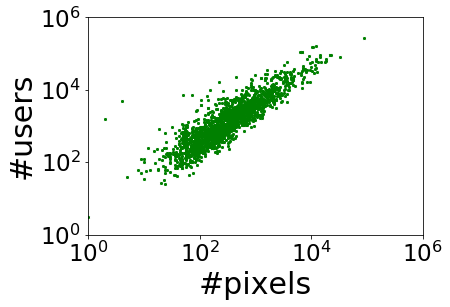

In [192]:
def plot_pixels_vs_users(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('#users', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1,1000000)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_users(X, Y, "../plots/plot_pixels_vs_users.svg")

In [145]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.84457543],
       [0.84457543, 1.        ]])

In [146]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [147]:
#Users/pixel

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    usr = users_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", pixels: ", pix, ", users/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  The purple corner , users:  4849 , pixels:  4 , users/pixel:  1212.25         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 1 , project:  PINLAND , users:  1589 , pixels:  2 , users/pixel:  794.5         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 2 , project:  Trans Heart , users:  7072 , pixels:  51 , users/pixel:  138.66666666666666         , 
description:  The first heart created by /r/TransFlagPlace, marking the centerpoint of the flag. 

# 3 , project:  (covered) 7-1 , users:  6895 , pixels:  72 , users/pixel:  95.76388888888889         , 
description:  The corner of the Brazil Flag that was

In [148]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    usr = users_per_project[proj]
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", users: ", usr, ", pixels: ", pix, ", users/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Bread , users:  43 , pixels:  65 , users/pixel:  0.6615384615384615         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 2 , project:  Bread , users:  51 , pixels:  77 , users/pixel:  0.6623376623376623         , 
description:  It's bread. 

# 3 , project:  Seplunky , users:  236 , pixels:  336 , users/pixel:  0.7023809523809523         , 
description:  Player character from the platform indie game Spelunky. 

# 4 , project:  Toucan , users:  273 , pixels:  326 , users/pixel:  0.8374233128834356         , 
description:  le toucan has arrived sheepoToucan 

# 5 , project:  Foliat , users:  180 , pixels:  206 , users/pixel:  0.873

In [371]:
#Pixels vs. time per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    t = times_per_project[p] / (1000 * 60 * 60)
    pix = pixels_per_project[p]
    
    Y[i] = t 
    X[i] = pix
    
    ratios[p] = t / pix
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [372]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('time (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#pixels', fontsize=30)
ax.set_xscale('log')
ax.set_ylim(0,100)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

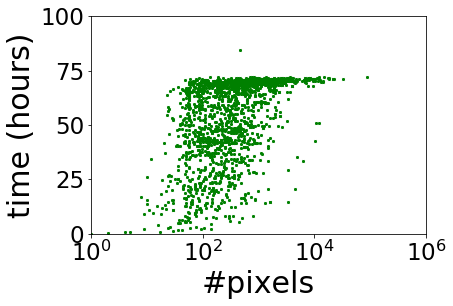

In [278]:
def plot_pixels_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('time (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#pixels', fontsize=30)
    ax.set_xscale('log')
    ax.set_ylim(0,100)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_pixels_vs_times(X, Y, "../plots/plot_pixels_vs_times.svg")

In [151]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.18451768],
       [0.18451768, 1.        ]])

In [152]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [154]:
#Time/Pixel

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", pixels: ", pix, ", time/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  The Tree , time:  34.255 , pixels:  12 , time/pixel:  10276500.0         , 
description:  On a canvas dominated by fierce territorialism and grandiose schemes, The Tree cast aside these common ideologies to become something simple, something pure.
The Tree represents a common principle to its followers, the idea of not getting wholly caught up in the rush, the flow of the crowd, the ability to stand on one's own feet, the ability to look back and say to oneself, "I will not be blinded by faith."
The Tree represents this just by being what it is, a small part of a much, much larger crowd. In that regard, The Tree also represents us all. We are The Tree, and The Tree is all of us. So while the tree may have been destroyed, it is still alive in all of us. 

# 1 , project:  Danish Heart , time:  63.8975 , pixels:  23 , time/pixel:  10001347.826086957         , 
description:  The flag of Denmark, or Dannebrog, in the shape of a heart, was almost overtaken by the /r/sweden 



In [285]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    pix = pixels_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", pixels: ", pix, ", time/pixel: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , pixels:  1 , time/pixel:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  osu! Logo , time:  33.25222222222222 , pixels:  6204 , time/pixel:  6.152031463405208e-05         , 
description:  The logo for the rhythm game osu. This was one of the more ambitious projects of /r/place and was intended to be more detailed. Unfortunately, a LoL player by the name of loltyler1, told his fans to attack the logo by filling it with the void, resulting in its current vandalized state. 

# 3 , project:  The purple corner , time:  0.5097222222222222 , pixels:  4 , time/pixel:  6.618909521130012e-05         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplep

In [373]:
#Users vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    ent = entropy_per_project[p]
    
    Y[i] = ent
    X[i] = usr
    
    ratios[p] = ent / usr
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [374]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('entropy', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#users', fontsize=30)
ax.set_xscale('log')
ax.set_yticks(np.arange(0.69, math.exp(1)+.1, .69))
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

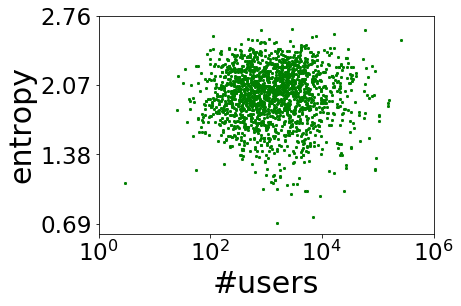

In [299]:
def plot_users_vs_entropy(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('entropy', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#users', fontsize=30)
    ax.set_xscale('log')
    ax.set_yticks(np.arange(0.69, math.exp(1)+.1, .69))
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_vs_entropy(X, Y, "../plots/plot_users_vs_entropy.svg")

In [430]:
#Correlation

np.corrcoef(X, Y)

array([[ 1.        , -0.01457834],
       [-0.01457834,  1.        ]])

In [291]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [292]:
#Entropy/User

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    ent = entropy_per_project[proj] 
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", users: ", usr, ", entropy/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Climber's Head (TowerClimb) , entropy:  1.0986122886681096 , users:  3 , entropy/user:  0.36620409622270317         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 1 , project:  Smiley Face , entropy:  2.1679025503594818 , users:  26 , entropy/user:  0.08338086732151853         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  The R , entropy:  1.8216729838184715 , users:  25 , entropy/user:  0.07286691935273887         , 
description:  The R of the sub r/The_R 

# 3 , project:  Italy heart , entropy:  2.0908155810619586 , users:  32 , entropy/user:  0.06533798690818621         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 4 , project:  Make Trade Fair , entropy:  2.23330011555482 , users:  35 , entropy/user:  0.06380857473013772         , 
description:  An organizatio

In [293]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    ent = entropy_per_project[proj] 
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", users: ", usr, ", entropy/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Rainbow Road , entropy:  2.5201075806834554 , users:  266766 , entropy/user:  9.446884463100453e-06         , 
description:  One of the first projects on r/place, and also one of the largest. It integrates itself with many other artworks. 

# 2 , project:  USA / Canvas Center , entropy:  1.9258022777284207 , users:  158121 , entropy/user:  1.2179294829456054e-05         , 
description:  The center of the canvas was a controversial and disputed part of r/place. It began to be filled with numerous randomly placed pixels. As organized groups began creating masterpieces, the center began a white void, part of r/erase. As the original (dark) Void began to eat the center of the canvas, the USA Flag began to take shape covering a branch from the void. The flag took over the white void and a few projects including a smiley and a tree. Then the void reappeared in place and with other people erased most of the flag as RainbowRoad expanded where the flag was. Ireland saw an opport

In [375]:
#Users vs. time per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    usr = users_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    Y[i] = t
    X[i] = usr
    
    ratios[p] = t / usr
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [376]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_ylabel('times (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_xlabel('#users', fontsize=30)
ax.set_xscale('log')
ax.set_ylim(0,100)
ax.set_xlim(1,1000000)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

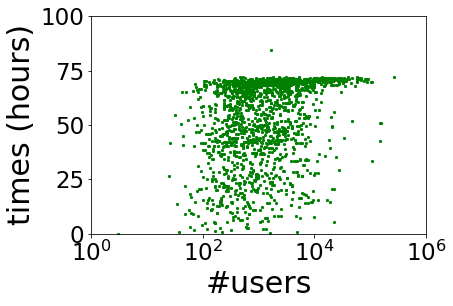

In [301]:
def plot_users_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_ylabel('times (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_xlabel('#users', fontsize=30)
    ax.set_xscale('log')
    ax.set_ylim(0,100)
    ax.set_xlim(1,1000000)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_users_vs_times(X, Y, "../plots/plot_users_vs_times.svg")

In [437]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.14488014],
       [0.14488014, 1.        ]])

In [304]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [305]:
#Time/User

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", users: ", usr, ", time/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Italy heart , time:  54.689166666666665 , users:  32 , time/user:  1.7090364583333333         , 
description:  A random heart or a symbol of cooperation between Scott Pilgrim and Italy? 

# 1 , project:  Smiley Face , time:  41.72138888888889 , users:  26 , time/user:  1.6046688034188035         , 
description:  A universal symbol of happiness rendered on a small scale for bite sized fun. 

# 2 , project:  Bread , time:  65.08055555555555 , users:  43 , time/user:  1.513501291989664         , 
description:  A loaf of Bread constructed by a few users of Anarchist subreddits to represent the ideas of Pyotr Kropotkin, Russian anarchist and author of the influential anarchist book, 'The Conquest of Bread'. Since this was a relatively late addition to the place, and is not a particularly obviously Leftist symbol, the Bread saw little vandalism and required no bots to maintain. 

# 3 , project:  Bread , time:  65.08055555555555 , users:  51 , time/user:  1.2760893246187361   

In [306]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    usr = users_per_project[proj]
    
    print("#", i, ", project: ", name, ", time: ", tm, ", users: ", usr, ", time/user: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  Climber's Head (TowerClimb) , time:  0.0 , users:  3 , time/user:  0.0         , 
description:  These inconspicuous 4 pixels are actually the head of the protagonist from the roguelike platformer game "TowerClimb". 

# 2 , project:  The purple corner , time:  0.5097222222222222 , users:  4849 , time/user:  0.00010511903943539331         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 3 , project:  PINLAND , time:  0.30694444444444446 , users:  1589 , time/user:  0.00019316830990839803         , 
description:  It was very common for users to change these few pixels so the F turned into a P 

# 4 , project:  D.Va Bunny , time:  5.251666666666667 , users:  22

In [379]:
#Time vs. entropy per project

X = np.zeros(len(updates_per_project))
Y = np.zeros(len(updates_per_project))
ratios = {}
IDs = []

i = 0
for p in updates_per_project.keys():
    ent = entropy_per_project[p]
    t = times_per_project[p] / (1000 * 60 * 60)
    
    Y[i] = ent
    X[i] = t
    
    if t > 0:
        ratios[p] = ent / t
    
    IDs.append(names[int(p)])
    
    i = i + 1
    
IDs = np.array(list(IDs), dtype=object)

In [380]:
%matplotlib tk

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)

fig, ax = plt.subplots()
sc = ax.scatter(X, Y, color="green", marker='x', s=5)
ax.scatter(X, Y, color="green", marker='x', s=5)
ax.set_xlabel('times (hours)', fontsize=30)
ax.tick_params(labelsize=23)
ax.set_ylabel('entropy', fontsize=30)
ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
ax.set_xlim(0,100)
    
annot = ax.annotate("", xy=(0,0), xytext=(5,5),textcoords="offset points", size=14)
annot.set_visible(False)   

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format("".join(IDs[ind["ind"]]))
    annot.set_text(text)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
    
fig.canvas.mpl_connect("motion_notify_event", hover)

5

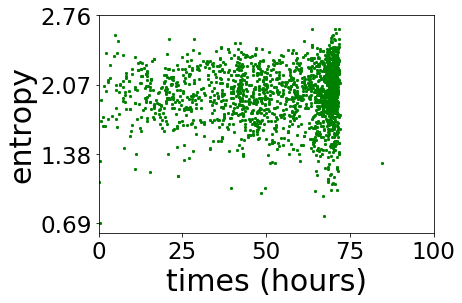

In [308]:
def plot_entropy_vs_times(X, Y, output_file_name):
    plt.clf()

    ax = plt.subplot(111)
    ax.scatter(X, Y, color="green", marker='x', s=5)
    ax.set_xlabel('times (hours)', fontsize=30)
    ax.tick_params(labelsize=23)
    ax.set_ylabel('entropy', fontsize=30)
    ax.set_yticks(np.arange(0.69,math.exp(1)+.1, .69))
    ax.set_xlim(0,100)
    plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_entropy_vs_times(X, Y, "plot_entropy_vs_times.svg")

In [309]:
#Correlation

np.corrcoef(X, Y)

array([[1.        , 0.02066956],
       [0.02066956, 1.        ]])

In [310]:
sorted_ratios = sorted(ratios.items(), key=operator.itemgetter(1), reverse=True)

In [311]:
#Entropy/Time

for i in range(10):
    proj = sorted_ratios[i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    ent = entropy_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", time: ", tm, ", entropy/time: ", r, "\
        , \ndescription: ", desc, "\n")    

# 0 , project:  Eightfold , entropy:  1.7075036453641854 , time:  0.6638888888888889 , entropy/time:  2.5719720181217856         , 
description:  What remains of Eightfold, a paper spider character from a webcomic called Paranatural. 

# 1 , project:  The purple corner , entropy:  1.302178642906814 , time:  0.5097222222222222 , entropy/time:  2.554682896165957         , 
description:  Originally a "colony" of the blue corner, a loss of interest among blue corner pixel-placers lead to the upper-left corner of the canvas being taken over by the faction that would eventually become /r/purplepixels. However, like all of the colour factions that dominated the early Place, the purple corner was eventually crowded out by pixel art. 

# 2 , project:  Gold Codfish , entropy:  1.9147854753595217 , time:  0.8355555555555556 , entropy/time:  2.2916315529568743         , 
description:  The /r/portugal equivalent of reddit gold. Given to topics and posts of high quality in the subreddit (mod flair) 

In [314]:
for i in range(1,11):
    proj = sorted_ratios[-i][0]
    name = names[int(proj)]
    desc = descriptions[int(proj)]
    r = sorted_ratios[-i][1]
    tm = times_per_project[proj] / (1000 * 60 * 60)
    ent = entropy_per_project[proj]
    
    print("#", i, ", project: ", name, ", entropy: ", ent, ", time: ", tm, ", entropy/time: ", r, "\
        , \ndescription: ", desc, "\n")    

# 1 , project:  (covered) 7-1 , entropy:  0.7545123567706904 , time:  67.4075 , entropy/time:  0.011193299807450067         , 
description:  The corner of the Brazil Flag that was vandalized over in over again in an attempt to shame Brazil for their 7-1 defeat against Germany in the 2014 world cup. Now all that remains is a single pixel of where the 7 starts 

# 2 , project:  Letter battle , entropy:  1.0174379097233763 , time:  71.06333333333333 , entropy/time:  0.014317340068343398         , 
description:  During the making of this, there was a lot of sabotage to the logo from peasants who can't stand the master race, and the FPS was changed a lot and started at 60FPS but exploded to a enormous number towards the end of R/place to show that PCMasterRace have no limitations.  

# 3 , project:  Hanzo Switch Pls , entropy:  0.962231222075264 , time:  67.06583333333333 , entropy/time:  0.014347562301846655         , 
description:  After initially writing "Switch" here, the words "Hanzo" 